**Objetivo:**

Se intentará predecir principalmente la posibilidad de reingreso para los diferentes pacientes a través del diagnóstico GRD que tengan. Con ello, se escoge finalmente la Ruta B del trabajo.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

In [42]:
grd = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/grd_2023_saved.parquet'
hospital = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/hospital.parquet'
ir_grd = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/ir-grd.parquet'
cie = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/CIE-10%20(2).xlsx'

## Obtener DataFrame
1.- Realizamos los tratamientos necesarios para la hacer el merge con los datos.  
2.- A partir de crear el DataFrame Principal revisamos los datos que tenemos y vemos los nulos.

In [43]:
df_grd = pd.read_parquet(grd)
df_hospital = pd.read_parquet(hospital)
df_ir_grd = pd.read_parquet(ir_grd)
df_cie = pd.read_excel(cie, engine='openpyxl')
# hospital, ir_grd no tienen header
df_ir_grd.columns = ['IR_29301_COD_GRD', 'DESCCRIPCION_GRD']
df_hospital.columns = ['COD_HOSPITAL', 'HOSPITAL']

# Limpiar nombres de columnas antes
for df in [df_grd, df_hospital, df_ir_grd, df_cie]:
    df.columns = df.columns.str.strip()

# Hacer los merges
df_grd = df_grd.merge(df_hospital, on='COD_HOSPITAL', how='left')
df_grd = df_grd.merge(df_ir_grd, on='IR_29301_COD_GRD', how='left')
df_grd = df_grd.merge(df_cie, left_on='DIAGNOSTICO1', right_on='Código', how='left')

# Luego eliminas columnas de unión
df_grd = df_grd.drop(columns=['COD_HOSPITAL', 'IR_29301_COD_GRD', 'DIAGNOSTICO1', 'Código'])
df_grd.head(2)

CIP_ENCRIPTADO    SEXO FECHA_NACIMIENTO            SERVICIO_SALUD  \
0      72196813.0  HOMBRE       1980-04-13                  VALDIVIA   
1             NaN  HOMBRE       2001-11-04  METROPOLITANO SURORIENTE   

  TIPO_INGRESO FECHA_INGRESO   FECHAALTA   TIPOALTA  IR_29301_PESO  \
0     URGENCIA    2023-03-12  2023-03-14  DOMICILIO         0.7094   
1     URGENCIA    2023-11-04  2023-11-10  DOMICILIO         1.0869   

   IR_29301_SEVERIDAD  IR_29301_MORTALIDAD  EDAD  DIAS_ESTANCIA  \
0                 1.0                  1.0  43.0              2   
1                 1.0                  1.0  22.0              6   

                                            HOSPITAL  \
0               Hospital Clínico Regional (Valdivia)   
1   Complejo Hospitalario Dr. Sótero del Río (San...   

                                    DESCCRIPCION_GRD    Versión  \
0          MH INFECCIONES GASTROINTESTINALES MAYORES  CIE-v2013   
1   PH PROCEDIMIENTOS MODERADAMENTE COMPLEJOS SOB...  CIE-v2013   

                                    Descripción              Categoría  \
0  Apendicitis aguda con peritonitis localizada  K35 APENDICITIS AGUDA   
1          Otros tipos de neumotórax espontáneo         J93 NEUMOTÓRAX   

                                    Sección  \
0        K35-K38  ENFERMEDADES DEL APÉNDICE   
1  J90-J94  OTRAS ENFERMEDADES DE LA PLEURA   

                                            Capítulo  
0  Cap.11  ENFERMEDADES DEL APARATO DIGESTIVO (K0...  
1  Cap.10  ENFERMEDADES DEL APARATO RESPIRATORIO ...

In [44]:
df_grd['CIP_ENCRIPTADO'].isna().mean() #0.0015727399438430838 de valores nulos.

#Eliminar columnas que no se usan, pues es un valor mínimo e irrelevante, dado que no podemos trazar a estas personas.
df_grd['CIP_ENCRIPTADO'].dropna(inplace=True);

In [45]:
print("Porcentaje valores duplicados: ", df_grd['CIP_ENCRIPTADO'].duplicated().mean()*100)
#21.13% de valores duplicados, por lo cual tenemos buena muestra para ver los reingresos.

Porcentaje valores duplicados:  21.130602825929913


Se buscan valores duplicados en la identificación de los pacientes (CIP_ENCRIPTADO); esto indica que son aquellos pacientes con más de una entrada dentro de la base de datos, es decir, ingresaron más de una vez al sistema por un tratamiento GRD. Se crearán nuevas columnas con los diferentes tiempos entre primera y posterior estadía, así como variables dummies que indiquen si el reingreso estuvo antes de ciertos días. 

In [46]:
# Asegura el tipo datetime
df_grd['FECHA_INGRESO'] = pd.to_datetime(df_grd['FECHA_INGRESO'])
df_grd['FECHAALTA']     = pd.to_datetime(df_grd['FECHAALTA'])

# Ordena episodios dentro de cada paciente
df_sorted = (
    df_grd
      .sort_values(['CIP_ENCRIPTADO', 'FECHA_INGRESO'])
      .reset_index(drop=True)
)

# Fecha del próximo ingreso
df_sorted['NEXT_FECHA_INGRESO'] = (
    df_sorted
      .groupby('CIP_ENCRIPTADO')['FECHA_INGRESO']
      .shift(-1)                       # episodio siguiente
)

# Diferencia en días (sólo si hay próximo episodio)
df_sorted['DIAS_REINGRESO'] = (
    (df_sorted['NEXT_FECHA_INGRESO'] - df_sorted['FECHAALTA'])
      .dt.days
)

mask_gap_ok = df_sorted['DIAS_REINGRESO'] >= 0
df_gaps     = df_sorted[mask_gap_ok].copy()

n_total_ep      = len(df_sorted)                    # todos los episodios
n_con_gap       = len(df_gaps)                      # episodios con reingreso calculable
pct_ep_con_gap  = n_con_gap / n_total_ep * 100      # Porcentaje pacientes con reingreso calculable

n_pac_total     = df_sorted['CIP_ENCRIPTADO'].nunique()  # número de pacientes únicos
n_pac_multiep   = df_sorted.loc[mask_gap_ok, 'CIP_ENCRIPTADO'].nunique() # número de pacientes con al menos un reingreso
pct_pac_multiep = n_pac_multiep / n_pac_total * 100 # porcentaje de pacientes con reingreso, del total de pacients

n_total_ep, n_con_gap, pct_ep_con_gap, n_pac_total, n_pac_multiep, pct_pac_multiep


(1039587, 214693, 20.651758823455854, 819915, 149882, 18.28018758041992)

In [47]:
# --- Parámetros ---
WINDOWS = [7, 30, 60, 90]       #Ventanas a analizar

# --- Función auxiliar: True si reingresa en ≤ w días ---
def etiqueta_reingreso_episodio(df, w):
    #1) Si DIAS_REINGRESO es NaN  -> No se observó reingreso (False)
    #2) Si gap >= 0 y <= w        -> True
    return (df['DIAS_REINGRESO'] <= w).fillna(False)

# --- crear etiquetas ---
for w in WINDOWS:
    df_sorted[f'READM_{w}D'] = etiqueta_reingreso_episodio(df_sorted, w).astype(int)
df_util = df_sorted[df_sorted['DIAS_REINGRESO']  > 0].copy() # sólo episodios con reingreso positivo
df_util.head(3)

CIP_ENCRIPTADO    SEXO FECHA_NACIMIENTO            SERVICIO_SALUD  \
1      66988070.0  HOMBRE       1977-07-12  METROPOLITANO SURORIENTE   
3      66988091.0   MUJER       1957-11-01   LIBERTADOR B. O HIGGINS   
4      66988091.0   MUJER       1957-11-01   LIBERTADOR B. O HIGGINS   

  TIPO_INGRESO FECHA_INGRESO  FECHAALTA   TIPOALTA  IR_29301_PESO  \
1     URGENCIA    2023-03-29 2023-04-13  DOMICILIO         1.1263   
3   PROGRAMADA    2023-07-17 2023-07-17  DOMICILIO         0.8479   
4     URGENCIA    2023-08-19 2023-08-31  DOMICILIO         0.6339   

   IR_29301_SEVERIDAD  ...                                        Descripción  \
1                 3.0  ...             Falla y rechazo de trasplante de riñón   
3                 0.0  ...  Diabetes mellitus, no especificada, con compli...   
4                 2.0  ...                  Várices esofágicas con hemorragia   

                                           Categoría  \
1  T86 FALLA Y RECHAZO DEL TRASPLANTE DE ÓRGANOS ...   
3             E14 DIABETES MELLITUS, NO ESPECIFICADA   
4                             I85 VÁRICES ESOFÁGICAS   

                                             Sección  \
1  T80-T88  COMPLICACIONES DE LA ATENCIÓN QUIRÚRG...   
3                         E08-E14  DIABETES MELLITUS   
4  I80-I89  ENFERMEDADES DE VENAS, VASOS Y GANGLI...   

                                            Capítulo NEXT_FECHA_INGRESO  \
1  Cap.19  LESIONES TRAUMÁTICAS, ENVENENAMIENTOS ...         2023-06-22   
3  Cap.04  ENFERMEDADES ENDOCRINAS, NUTRICIONALES...         2023-08-19   
4  Cap.09  ENFERMEDADES DEL APARATO CIRCULATORIO ...         2023-09-01   

  DIAS_REINGRESO READM_7D READM_30D READM_60D READM_90D  
1           70.0        0         0         0         1  
3           33.0        0         0         1         1  
4            1.0        1         1         1         1  

[3 rows x 26 columns]

**Medidas de tendencia central y dispersión**

Se presentan diferentes medidas descriptivas para variables que interesan o pueden interesar a futuro:
- Dias de Reingreso: Variable principal en la que se basará la investigación.
- Edad: Variable interesante que se verá tiene relación con el reingreso.
- Mortalidad: Variable interesante que se verá si tiene relación con reingreso y diferentes diagnósticos.

In [48]:
print("Medidas descriptivas para los días de reingreso:")
print(df_util['DIAS_REINGRESO'].describe())
print("\nMedidas descriptivas para la edad:")
print(df_util['EDAD'].describe())
print("\nMedidas descriptivas para la mortalidad:")
print(df_util['IR_29301_MORTALIDAD'].describe())

Medidas descriptivas para los días de reingreso:
count    200236.000000
mean         59.932205
std          66.778633
min           1.000000
25%          12.000000
50%          33.000000
75%          86.000000
max         360.000000
Name: DIAS_REINGRESO, dtype: float64

Medidas descriptivas para la edad:
count    200234.000000
mean         48.130342
std          25.850894
min           0.000000
25%          28.000000
50%          53.000000
75%          70.000000
max         105.000000
Name: EDAD, dtype: float64

Medidas descriptivas para la mortalidad:
count    200233.000000
mean          1.483677
std           0.988125
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: IR_29301_MORTALIDAD, dtype: float64


**Gráficos**

Profundizaremos con diferentes gráficos para observar posibles tendencias y/o relaciones que se puedan presentar.

In [49]:
# --- Histograma con dias de reingreso---
import plotly.express as px
fig = px.histogram(df_util, x="DIAS_REINGRESO", nbins=75)
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_yaxes(title="Cantidad de episodios")
fig.update_xaxes(dtick=30, title="Días hasta el reingreso")

fig.show()

In [50]:
# ---Histograma con días de reingreso por género---
fig = px.histogram(
    df_util,
    x="DIAS_REINGRESO",
    nbins=75,
    facet_col="SEXO",             
    color="SEXO",                
    opacity=0.8
)

fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_yaxes(title="Cantidad de episodios")
fig.update_layout(title="Distribución de días hasta el reingreso por sexo (≤ 300 días)")

fig.show()

Se observa una posible tendencia exponencial en la fecha de reingresos. Lo que nos puede indicar relación entre diagnóstico y recaída, debido a los pocos días entre cada ingreso. Así mismo, se puede observar la misma tendencia sin importar el género, observando gráficos similares entre ambos.

Seguiremos explorando si existe alguna relación con el tipo de motivo de reingreso.  

In [51]:
# === 1.a  Opción A: usar TIPO_INGRESO (pocas categorías) ============
df_plot = df_sorted[['TIPO_INGRESO', 'DIAS_REINGRESO']].copy()

# === 1.b  Opción B: usar diagnóstico ================================
#  Usamos CAPÍTULO (nivel alto) para no tener cientos de códigos
df_plot = df_sorted[['Capítulo', 'DIAS_REINGRESO']].rename(columns={'Capítulo':'MOTIVO'})
df_plot['MOTIVO'] = df_plot['MOTIVO'].fillna('SIN_INF')


def correlation_ratio(categories, values):
    """
    η (eta) para numérico vs. categórico.
    0 = sin asociación, 1 = perfecta.
    """
    cat_groups = {}
    for cat, val in zip(categories, values):
        cat_groups.setdefault(cat, []).append(val)
    # media global
    grand_mean = np.nanmean(values)
    # Suma de cuadrados inter-grupos y total
    ss_between = sum(len(v)*((np.nanmean(v)-grand_mean)**2) for v in cat_groups.values())
    ss_total   = np.nansum((values - grand_mean)**2)
    return np.sqrt(ss_between / ss_total)

eta = correlation_ratio(df_plot.iloc[:,0], df_plot['DIAS_REINGRESO'])
print(f"η num‑cat = {eta:0.3f}")


η num‑cat = 0.304


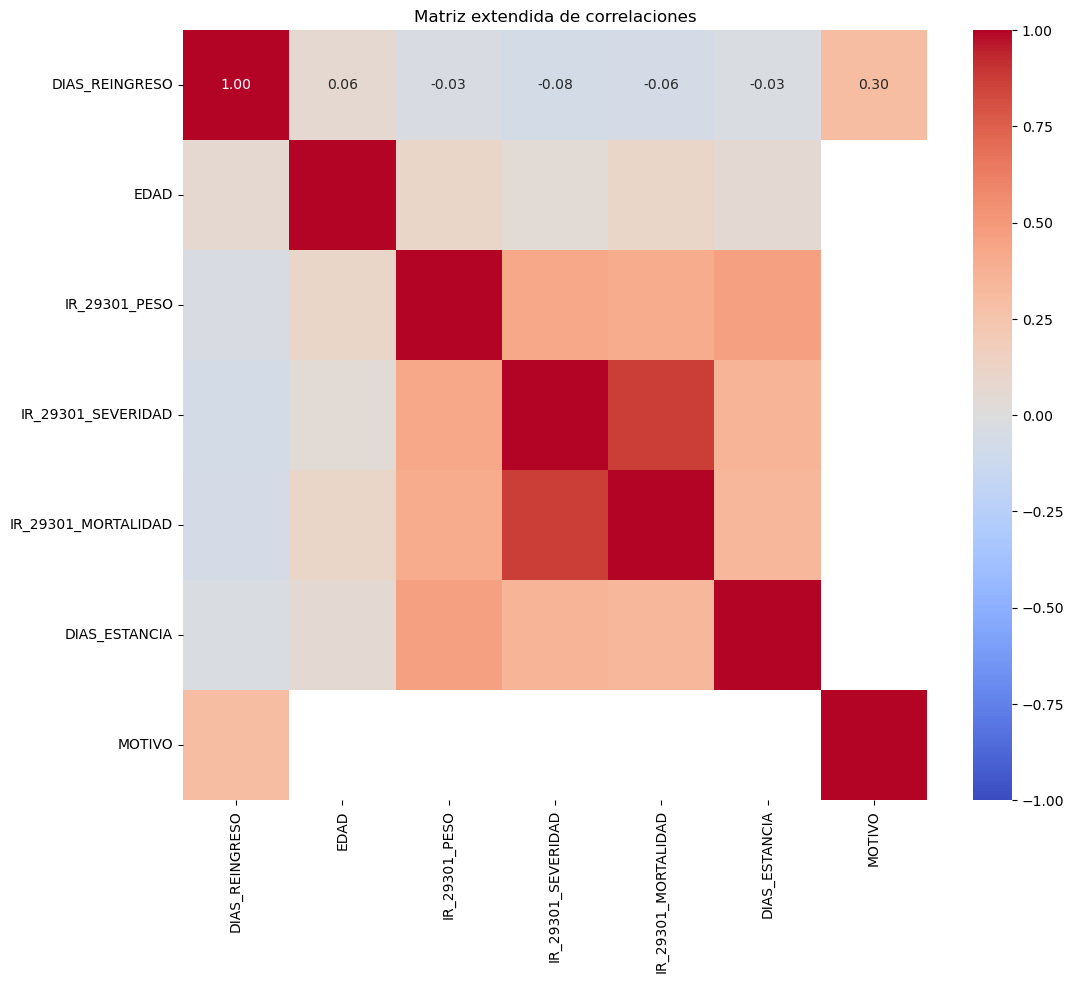

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Correlaciones numéricas estándar
num_cols = ['DIAS_REINGRESO', 'EDAD', 'IR_29301_PESO',
            'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD', 'DIAS_ESTANCIA']
corr_num = df_sorted[num_cols].corr()

# 2) Añade nueva fila/columna con η
corr_matrix = corr_num.copy()
corr_matrix.loc['DIAS_REINGRESO', 'MOTIVO'] = eta
corr_matrix.loc['MOTIVO', 'DIAS_REINGRESO'] = eta
corr_matrix.loc['MOTIVO', 'MOTIVO'] = 1        # Autocorrelación

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1,
            cmap='coolwarm', fmt='.2f', mask=corr_matrix.isna())
plt.title('Matriz extendida de correlaciones')
plt.show()


No se ve una correlación clara entre los días de reingreso y el resto de variables, sin embargo, el motivo tiene una correlación positiva un poco más alta. También, pueden existir relaciones no lineales que no se están tomando en cuenta en la matriz, en base a ello, se continuarán realizando análisis.

Se busca observar los diferentes episodios por los cuales ingresan, y, aquellos que tienen la menor cantidad de días de reingreso promedio, para lo que se genera el siguiente gráfico:

In [53]:
media_cat = (
    df_plot
      .groupby(df_plot.columns[0])['DIAS_REINGRESO']
      .mean()
      .sort_values(ascending=True)
      .reset_index()
)

fig = px.bar(media_cat, x=df_plot.columns[0], y='DIAS_REINGRESO',
             title='Días medios hasta reingreso por motivo', text_auto='.1f')
fig.update_layout(xaxis_title='Motivo de ingreso', yaxis_title='Días hasta reingreso')
fig.show()


Vemos el gráfico de las ventanas de reingreso.

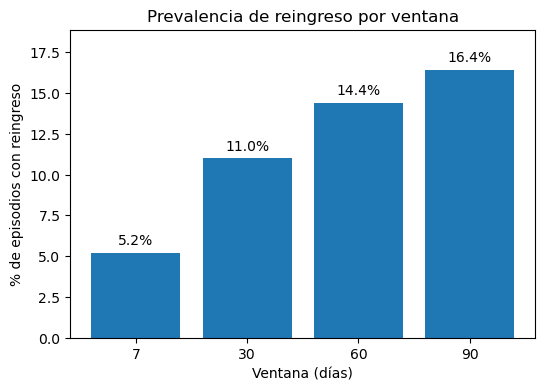

In [54]:
prev_ep  = [df_sorted[f'READM_{w}D'].mean()*100 for w in WINDOWS]

plt.figure(figsize=(6,4))
plt.bar([str(w) for w in WINDOWS], prev_ep)
plt.ylabel('% de episodios con reingreso')
plt.xlabel('Ventana (días)')
plt.title('Prevalencia de reingreso por ventana')
for x, y in zip(WINDOWS, prev_ep):
    plt.text(str(x), y+0.5, f'{y:0.1f}%', ha='center')
plt.ylim(0, max(prev_ep)*1.15)
plt.show()

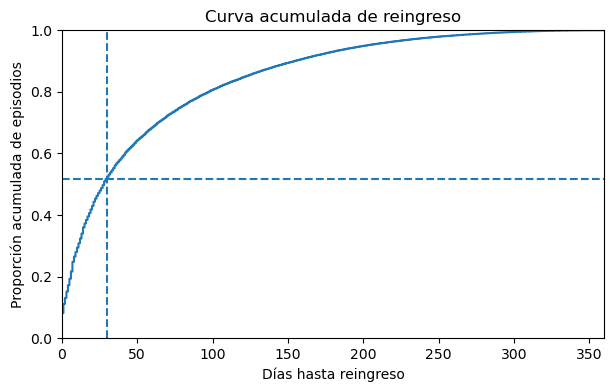

In [55]:
dias_vals = df_sorted['DIAS_REINGRESO'].dropna().values
dias_sorted = np.sort(dias_vals)

# proporción acumulada
cum_prop = np.arange(1, len(dias_sorted)+1) / len(dias_sorted)

plt.figure(figsize=(7,4))
plt.step(dias_sorted, cum_prop, where='post')
plt.axvline(30, linestyle='--')   # ejemplo de ventana
plt.axhline(cum_prop[dias_sorted.searchsorted(30)], linestyle='--')
plt.xlabel('Días hasta reingreso')
plt.ylabel('Proporción acumulada de episodios')
plt.title('Curva acumulada de reingreso')
plt.ylim(0,1)
plt.xlim(0, dias_sorted.max())
plt.show()

En función de la naturaleza de la variable que buscamos predecir, y, los diferentes resultados presentados en el notebook, podría ser útil generar un modelo de regresión logística que permita predecir a través de las diferentes características del paciente si este reingresará o no. Permitiendo la preparación a los actores de cualquier servicio de salud ante un próximo paciente. 

Notamos que, mientras más días transcurran ulterior a la atención del paciente, menos probable es que estos vuelvan a ingresar al sistema; nos parece bastante interesante y creemos que es un punto del cual podemos basarnos para abordar nuestra tesis inicial, en donde creemos condicen algunas de nuestras variables principales.
También, planteamos a futuros trabajos realizar análisis y predicciones sobre la supervivencia esperada de un individuo, basándonos en diferentes características descritas en el sistema.